### GEOG0051

Mining Social and Geographic Datasets
-----------------------------------

Machine Learning Analysis with Venue Review Data in Calgary, Canada
-------------------------------

Stephen Law, Igor Tkalec, Thomas Keel, and Gong Jie

For this second task, we would like you to analyse a dataset that contains review data of different venues in the city of Calgary,
Canada. With the help of several machine learning techniques that we have learnt in the course, you will be tasked to distill
insights from this social media dataset. Two of its notable features are the geocoding of every reviewed venues and the
availability of a considerable amount of text data in it, which lend to its ability to be processed using spatial and text analysis
techniques respectively.

As a prelude to the analysis prompts below, have a brief think about some of these questions: What can we discover about the
venue review data? Are there any spatial patterns that can be extracted from the data? Can we build a machine learning model
that predicts review rating for unseen data points using the text of the reviews?

### 3.1 Format of Data

The variables contained in the dataset provided in the `Calgary.csv` file, are:

* `business_id`, unique identifier of the premise
* `Name`, name of premise
* `latitude`, `longitude`, i.e. the locational attributes of the venue. <br/>
* `review_count` or the number of reviews the venue has been given<br/>
* `categories` general category of establishment that a venue falls under 
(Note: this variable is rather messy and might needs some cleaning/consolidation to be usable)<br/>
* `hours` or the opening hours of the venue <br/>
* `review_id` unique identifier of the review <br/>
* `user_id` unique identifier of the individual who left the review<br/>
* `stars_y` individual ratings of the venue<br/>
* `useful`, `funny`, `cool`, i.e. tags that the user attached to the review<br/>
* `text`, text of the review <br/>
* `date` i.e. the date of the review<br/>

### 3.2.1 Loading and cleaning the textual dataset


#### 3.2.1.1 Loading the data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import seaborn as sns
import time



from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.inspection import permutation_importance


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from scipy.sparse import hstack


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
  


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dicleecebulut/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dicleecebulut/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dicleecebulut/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [68]:
data = pd.read_csv('Calgary.csv')

#### 3.2.1.3 Positive/Negative Variable


Even though this step is not mentioned until 3.2.2, it is interesting to see the distribution of this variable alongside the other variables in the next step.

In [69]:
data['positive'] = data['stars_y'].apply(lambda x: 1 if x >= 4 else 0)
data

,business_id,name,latitude,longitude,review_count,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,positive
0,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",pltqT0DnejbWN-K32BD1Fg,v6zuRbp5jjHroawRiv9IhQ,5.0,1,0,0,David came in the spring to give me an estimat...,2017-08-16 01:10:52,1
1,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",8Iaf1YXNjo3zPd6-uLSJhg,UkL35C-EXA_yje4HeNINeQ,5.0,0,0,0,Chinook Landscaping is a Company that I would ...,2014-06-15 21:09:06,1
2,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",fTU0yYLj78NJftEKah-woQ,CXhdG2DP0aplOZPZtNFobw,5.0,0,0,0,Chinook Landscaping is tops in my book\nI was ...,2013-08-22 22:10:38,1
3,rdg0b0tHKvSCQNl6u3tS_A,SML Entertainment,51.084990,-113.989605,5,"Shopping, Caterers, Furniture Stores, Hot Tub ...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",2SGfqlKDjuFpXZ7LjdNJSQ,siNu6MF02MSMnoyPkaxZyg,5.0,5,0,0,If you are looking for a supplier of games tab...,2009-06-29 02:20:25,1
4,rdg0b0tHKvSCQNl6u3tS_A,SML Entertainment,51.084990,-113.989605,5,"Shopping, Caterers, Furniture Stores, Hot Tub ...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",5RfnOMsGcQ26EoXlteFOyw,-InhDRRVG7wrwsgAUvN4Qw,5.0,6,3,3,"SML is now a personal wet dream of mine, the e...",2009-12-03 17:29:51,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82177,knifdfgaeWZ-277S6lsSnA,Martin's Pest Control,50.905732,-114.066646,3,"Pest Control, Local Services","{'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...",pd7i8sxkMfbjdWR926nz8Q,zYLF37lcx2MPIHZVJjahBA,5.0,1,1,0,"I rarely post reviews, but wanted to express h...",2016-08-18 14:19:05,1
82178,knifdfgaeWZ-277S6lsSnA,Martin's Pest Control,50.905732,-114.066646,3,"Pest Control, Local Services","{'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...",Uu4txscaQB25tF5kuG4gkg,rlY-ah6vhTHiRkJMEtDJ-g,5.0,1,0,0,I used Martin's Pest Control for an under-conc...,2015-10-17 23:16:52,1
82179,Q4-TlHSvl45XMg2Y1wEVJQ,Home-Alyze,51.099332,-114.012717,3,"Home Services, Home Inspectors","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",kooH5UmJ5k-8USDe03jI9Q,Id5k4kNeblkyQSuteVURGQ,1.0,6,0,0,"This company came into my home, 'inspected' th...",2011-09-09 20:22:04,0
82180,Q4-TlHSvl45XMg2Y1wEVJQ,Home-Alyze,51.099332,-114.012717,3,"Home Services, Home Inspectors","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",2SUoFTckEOdGd1V7GpIvrg,grsdpOuwSdwN3ndafhfa9Q,1.0,3,0,0,I would never recommend them to anyone. I pur...,2013-08-02 07:21:12,0


#### 3.2.1.4 Describing numeric variables and checking distribution of these attributes


In [4]:
data.describe()

,latitude,longitude,review_count,stars_y,useful,funny,cool,positive
count,82182.000000,82182.000000,82182.000000,82182.000000,82182.000000,82182.000000,82182.000000,82182.000000
mean,51.042724,-114.070648,61.995254,3.618639,1.293203,0.391083,0.382578,0.640262
std,0.051552,0.053040,77.290191,1.424214,2.830347,1.306604,1.171075,0.479926
min,50.865169,-114.379523,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,51.033200,-114.086896,13.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,51.044727,-114.070254,36.000000,4.000000,0.000000,0.000000,0.000000,1.000000
75%,51.066428,-114.053056,78.000000,5.000000,2.000000,0.000000,0.000000,1.000000
max,51.207540,-113.714140,512.000000,5.000000,104.000000,59.000000,69.000000,1.000000


Checking the distribution of latitude and longitude doesn't give us any information. Therefore we exclude those attributes from our plotting stage.

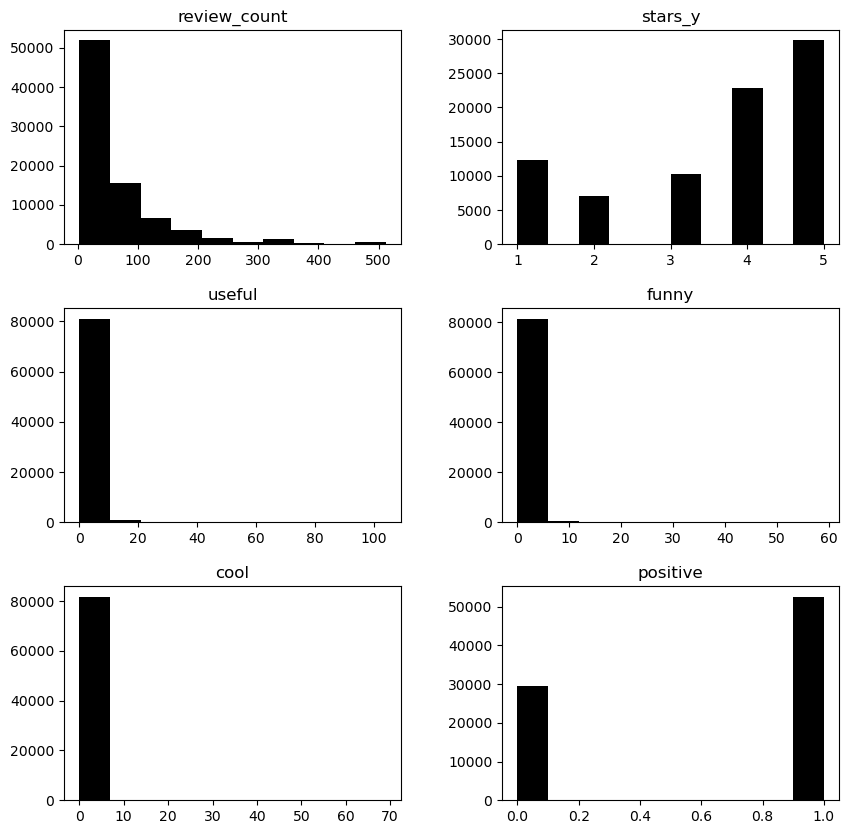

In [5]:
numeric_cols = ['review_count','stars_y', 'useful', 'funny', 'cool', 'positive']
numeric_data = data[numeric_cols]
numeric_data.hist(figsize=(10,10),color='black',grid=False)
#plt.axis(False)
plt.show()

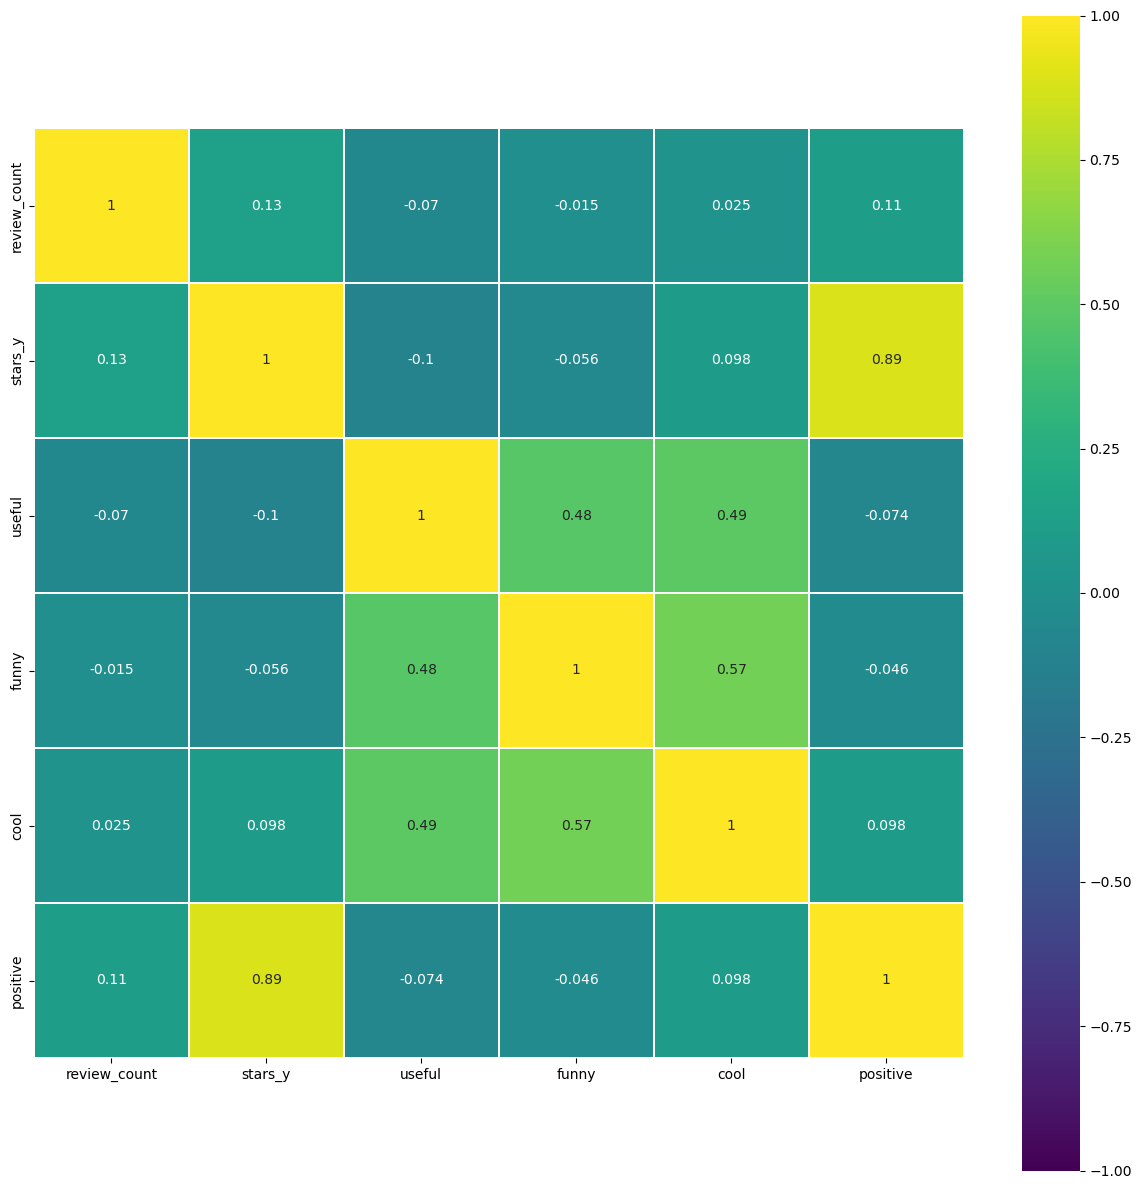

In [6]:
corr = data[numeric_data.columns].corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, center=0,cmap=plt.get_cmap('viridis'),
            square=True, linewidths=.05, annot=True, vmin=-1, vmax=1,ax=ax) 
plt.show()

#### 3.2.1.5 Discovering categorical variables


In [7]:
categorical_data = data.select_dtypes(include=[object])
categorical_data.columns

Index(['business_id', 'name', 'categories', 'hours', 'review_id', 'user_id',
       'text', 'date'],
      dtype='object')

We observe how business categories are inputted in the data for our future analysis

#### 3.2.1.6 Pre-process text reviews

We define a function to pre-process our text column. 
This function 
* removes punctuation and numbers, 
* turns words into lowercase, 
* tokenizes them, 
* removes stopwords, 
* lemmatizes the tokens
* joins the tokes back into a string.
At the end, we join this new pre-processed text as a new column to our data.

In [70]:
lemmatizer = WordNetLemmatizer()

# Define a function for text preprocessing
def preprocess_text(text):
     
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    #even though the punctuation is only removed for the words that are not in stop words
    #some comments just have stop words without punctuation (typos)
    #Therefore we remove them manually
    newStopWords = ['youre','youve',"youve", "youll", "youd", 
                    "shes", "thatll", "dont", "shouldve", "arent", 
                    "couldnt", "didnt", "doesnt", "hadnt", "hasnt", 
                    "havent", "isnt", "mightnt", "mustnt", "neednt",
                    "shant","shouldnt", "wasnt", "werent", "wont", 
                    "wouldnt", "i'm", "im"] 
    stop_words.update(newStopWords)
    #Lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = text.split()
    
    tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens if token not in stop_words]
    

    
    tokens = [token.translate(str.maketrans('', '', string.digits)) for token in tokens]
    
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text
data['preprocessed_text'] = data['text'].apply(preprocess_text)

### 3.2.2 Build a supervised learning for text analysis


#### 3.2.2.1 Models with only text 

We are definig the vectorizer that is going to be used in the model. Since we already have a column of cleaned data, we do not include a text cleaning process into this vectoriser.

This vectorizer removes the words that occur in more that 95% of the observations and less than 1% of the observations. This helps us remove words are too frequent too infrequent to be relevant to help our model classify observations.

We visualise the output of this vectorizer. 

In [9]:
text_column = data['preprocessed_text'].tolist()
#turns text data into feature vectors
vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=0.01)

#check how it looks
text_column_transformed = vectorizer.fit_transform(text_column)
pd.DataFrame(text_column_transformed.toarray(),columns=[vectorizer.get_feature_names_out()])

,able,about,absolutely,accommodating,across,actually,add,added,addition,afternoon,...,wrap,write,wrong,year,yelp,yes,yet,you,young,yummy
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82177,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
82178,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82180,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


However, there can be an even better way to vectorize our text data. We define a term frequency - inverse document frequency vectorizer (this improves the accuracy of our models).

In [10]:
#turns text data into feature vectors
tfidf_vectorizer = TfidfVectorizer( max_df=0.95, 
                                    min_df=0.01)

#check how it looks
text_column_tfidf = tfidf_vectorizer.fit_transform(text_column)
pd.DataFrame(text_column_tfidf.toarray(),columns=[tfidf_vectorizer.get_feature_names_out()])
    

,able,about,absolutely,accommodating,across,actually,add,added,addition,afternoon,...,wrap,write,wrong,year,yelp,yes,yet,you,young,yummy
0,0.132014,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.16307,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.102244,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82177,0.000000,0.0,0.0,0.0,0.0,0.134775,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.143407,0.0,0.0
82178,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
82179,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
82180,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


We test and train split our data. Our predictor is the preprocessed text and our target categories are positive and negative.

We apply a 10% test size. Then, we apply our vectorizer to the text train and text test sets. 

In [11]:
x_train, x_test, y_train, y_test = train_test_split(data, data.positive, 
                                                      test_size = 0.10, random_state = 1)
x_train_vectors = tfidf_vectorizer.transform(x_train.preprocessed_text)
x_test_vectors = tfidf_vectorizer.transform(x_test.preprocessed_text)


We define a function to print out necessary statistics (f1 score, accuracy score, mse, and r2) and visualisations for us to evaluate the model performance.

##### 3.2.2.1.a Defining Useful Functions

In [12]:
def printStats(y_test, y_pred):
    # y_test contains the true ratings and y_pred contains the predicted ratings
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
  
    print("MSE:", mse)
    print("R2-score:", r2)
   
        
    print ("F1 score:", f1_score(y_test, y_pred, average='macro'))
    print ("Accuracy:", accuracy_score(y_test, y_pred)) 
    
    #creates a grid to plot on
    f, ax = plt.subplots(figsize=(7, 5))
    #plots confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_pred),annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.show()

In [13]:
def crossVal(model, x_train, y_train, x_test, y_test):
# Evaluate the model using cross-validation
    cv_scores = cross_val_score(model, x_train, y_train, cv=5)

# Calculate the training and test accuracy of the model
    train_accuracy = model.score(x_train, y_train)
    test_accuracy = model.score(x_test, y_test)

# Compare the cross-validation score to the training and test accuracy
    if cv_scores.mean() > train_accuracy and cv_scores.mean() > test_accuracy:
        print("The model is likely overfitting.")
    else:
        print("The model is not overfitting.")


In [14]:
def permImp(model, x_test_vectors, y_test, feature_cols):

# convert the sparse matrix to a dense numpy array
    x_test_dense = x_test_vectors.toarray()

# calculate the permutation importance of the new features
    result = permutation_importance(model, x_test_dense, y_test, n_repeats=10, random_state=0)
    for i in result.importances_mean.argsort()[::-1]:
        if i >= len(result.importances_mean.argsort()) - len(feature_cols):
            print(f"{feature_cols[i-(len(result.importances_mean.argsort())-len(feature_cols))]}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

We fit our classifiers:
* Naive Bayes Classifier
* Logistic Regression Classifier
* Random Forest Classifier 
Disclaimer: Random Forest Classifier may take more time than the others. 

##### 3.2.2.1.b Naive Bayesian Model

MSE: 0.17958389098430466
R2-score: 0.22767863622924767
F1 score: 0.7895647736816485
Accuracy: 0.8204161090156954


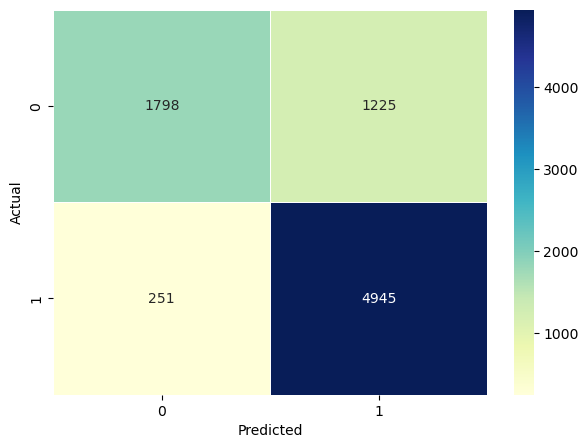

In [15]:
# Naive Bayes Classifier
clf = MultinomialNB()
clf.fit(x_train_vectors, y_train)

# this uses the Naive Bayes Classifier to predict
y_pred = clf.predict(x_test_vectors)
printStats(y_test, y_pred)

##### 3.2.2.1.c Logistic Regression Classifier Model

MSE: 0.13541793405523786
R2-score: 0.41761945943303025
F1 score: 0.8519128945945336
Accuracy: 0.8645820659447622


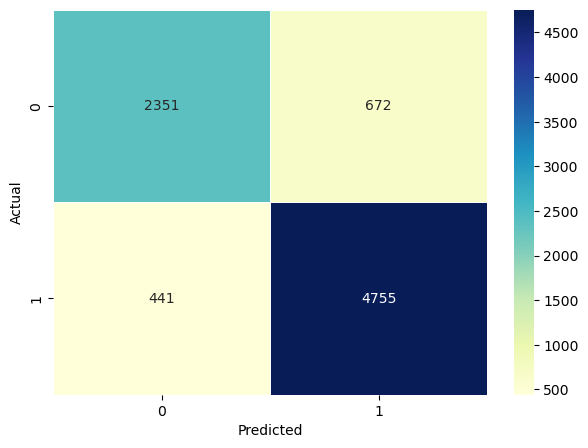

In [16]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

# fit the classifier on the training data
clf_logistic.fit(x_train_vectors, y_train)

# predict the labels of the test data
y_pred = clf_logistic.predict(x_test_vectors)
printStats(y_test, y_pred)

At some point, our logistic regression doesn't converge. We increase the maximum iteration to fix this. In the confusion matrix, we see that False Positives are disproportionally higher than false negatives. 


In [17]:
from sklearn.model_selection import cross_val_score

# split the data into 5 folds
cv = 5

# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

# perform k-fold cross-validation and compute the mean accuracy score
scores = cross_val_score(clf_logistic, x_train_vectors, y_train, cv=cv)

# print the mean accuracy score and its standard deviation
print("Mean accuracy: {:.2f}%, Standard deviation: {:.2f}%".format(scores.mean()*100, scores.std()*100))

Mean accuracy: 86.90%, Standard deviation: 0.23%


In [18]:

# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

    # define the range of penalty parameter values to explore
param_grid = {'C': [0.01, 0.1, 1, 10]}

    # create a grid search object with 5-fold cross-validation
grid_search = GridSearchCV(clf_logistic, param_grid, cv=5, scoring='accuracy')

    # fit the grid search object on the training data
grid_search.fit(x_train_vectors, y_train)
    

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.01, 0.1, 1, 10]}, scoring='accuracy')

In [20]:
def gridSearchLogReg(x_train_vectors, y_train):
    # create an instance of the Logistic Regression Classifier
    clf_logistic = LogisticRegression(max_iter=10000)

    # define the range of penalty parameter values to explore
    param_grid = {'C': [0.01, 0.1, 1, 10]}

    # create a grid search object with 5-fold cross-validation
    grid_search = GridSearchCV(clf_logistic, param_grid, cv=3, scoring='accuracy')

    # fit the grid search object on the training data
    grid_search.fit(x_train_vectors, y_train)
    
    print("Best parameters:", grid_search.best_params_, "Score:", grid_search.best_score_)
    return grid_search.best_estimator_

In [21]:
gridSearchLogReg(x_train_vectors, y_train)

Best parameters: {'C': 1} Score: 0.8685288949867217


LogisticRegression(C=1, max_iter=10000)

MSE: 0.13541793405523786
R2-score: 0.41761945943303025
F1 score: 0.8519128945945336
Accuracy: 0.8645820659447622


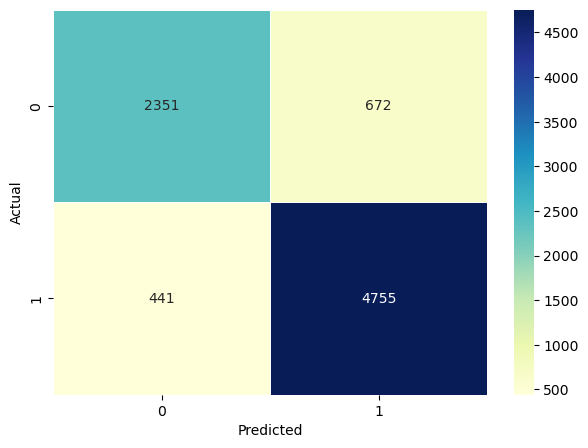

In [22]:

#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000, C=grid_search.best_params_['C'])

# fit the classifier on the training data
clf_logistic.fit(x_train_vectors, y_train)

# predict the labels of the test data
y_pred = clf_logistic.predict(x_test_vectors)
printStats(y_test, y_pred)

In [23]:
crossVal(clf_logistic, x_train_vectors, y_train, x_test_vectors, y_test )

The model is not overfitting.


##### 3.2.2.1.d Random Forest Classifier Model

Radom forest complete, elapsed time: 286.344003200531
MSE: 0.15804842438252828
R2-score: 0.32029440952695987
F1 score: 0.8231793305618653
Accuracy: 0.8419515756174717


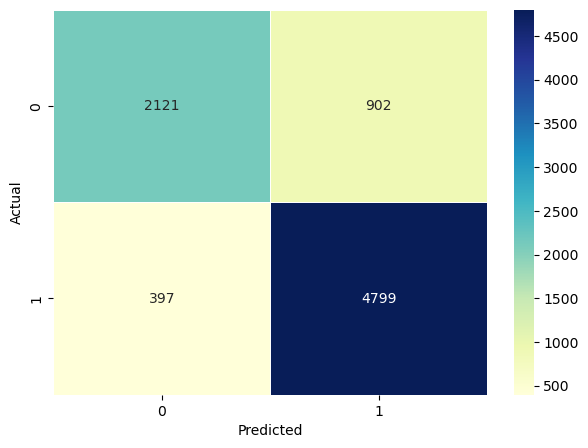

In [24]:
# Random Forest Classifier

start = time.time()
# create an instance of the Random Forest Classifier
clf_forest = RandomForestClassifier(random_state=1)

# fit the classifier on the training data
clf_forest.fit(x_train_vectors, y_train)

# predict the labels of the test data
y_pred = clf_forest.predict(x_test_vectors)

duration = time.time() - start
print("Radom forest complete, elapsed time:", duration)

printStats(y_test, y_pred)

In [25]:
#crossVal(clf_forest, x_train_vectors, y_train, x_test_vectors, y_test )
#takes too long to compute, approx 15 mins

###### 3.2.2.1.d.i Grid Search CV


In [26]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10, 30, 60, 100],
    'n_estimators': [10, 50, 100, 200, 300]
}
# Create a based model
model = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 3 # number of folds for cross validation
                           , n_jobs = -1 # use all processors
                            , verbose = 2 # what to display
                          )

In [28]:
grid_search.fit(x_train_vectors, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

In [ ]:
model = grid_search.best_estimator_
best_param = grid_search.best_params_
y_pred=model.predict(x_test_vectors)
print ('the out of sample test accuracy for a RandomForestClassifier is : '+ str(round(accuracy_score(y_test, y_pred),3)))

In [ ]:
best_param

In [ ]:
searchResults = pd.DataFrame(grid_search.cv_results_)
searchResults.head()
scores = searchResults.mean_test_score
depth = searchResults.param_max_depth
estimators = searchResults.param_n_estimators
estimators

In [ ]:
#create pivot table
grid_reset = searchResults.groupby(['param_max_depth', 'param_n_estimators'])["mean_test_score"].mean().reset_index()
grid_reset.columns = ['param_max_depth', 'param_n_estimators', 'mean_test_score']
grid_pivot = grid_reset.pivot('param_max_depth', 'param_n_estimators')
grid_pivot

In [ ]:
#plot 3D 
x = grid_pivot.columns.levels[1].values
y = grid_pivot.index.values
z = grid_pivot.values

plt.pcolor(x, y, z)
plt.colorbar()
plt.xlabel("n_estimators")
plt.ylabel("max_depth")

In [ ]:
# Random Forest Classifier

# create an instance of the Random Forest Classifier
clf_forest = RandomForestClassifier(random_state=1, **grid_search.best_params_)

# fit the classifier on the training data
clf_forest.fit(x_train_vectors, y_train)

# predict the labels of the test data
y_pred = clf_forest.predict(x_test_vectors)
printStats(y_test, y_pred)

#### 3.2.2.2 Models with text and non-text features

##### 3.2.2.2.a Sentiment Analysis (Lexicon Based) as a feature

In [29]:
sid = SentimentIntensityAnalyzer()

data['sentiment_score'] = data['preprocessed_text'].apply(lambda x: sid.polarity_scores(x)['compound'])


In [30]:
data

,business_id,name,latitude,longitude,review_count,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,positive,preprocessed_text,sentiment_score
0,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",pltqT0DnejbWN-K32BD1Fg,v6zuRbp5jjHroawRiv9IhQ,5.0,1,0,0,David came in the spring to give me an estimat...,2017-08-16 01:10:52,1,david came spring give estimate redoing centre...,0.8807
1,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",8Iaf1YXNjo3zPd6-uLSJhg,UkL35C-EXA_yje4HeNINeQ,5.0,0,0,0,Chinook Landscaping is a Company that I would ...,2014-06-15 21:09:06,1,chinook landscaping company would recommend ev...,0.9613
2,MbZMmwo-eL0Jnm_Yb9KJrA,Chinook Landscaping and Design,50.945960,-114.037207,3,"Contractors, Landscaping, Home Services","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",fTU0yYLj78NJftEKah-woQ,CXhdG2DP0aplOZPZtNFobw,5.0,0,0,0,Chinook Landscaping is tops in my book\nI was ...,2013-08-22 22:10:38,1,chinook landscaping top book extremely pleased...,0.9945
3,rdg0b0tHKvSCQNl6u3tS_A,SML Entertainment,51.084990,-113.989605,5,"Shopping, Caterers, Furniture Stores, Hot Tub ...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",2SGfqlKDjuFpXZ7LjdNJSQ,siNu6MF02MSMnoyPkaxZyg,5.0,5,0,0,If you are looking for a supplier of games tab...,2009-06-29 02:20:25,1,looking supplier game table pool cue accessory...,0.9738
4,rdg0b0tHKvSCQNl6u3tS_A,SML Entertainment,51.084990,-113.989605,5,"Shopping, Caterers, Furniture Stores, Hot Tub ...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",5RfnOMsGcQ26EoXlteFOyw,-InhDRRVG7wrwsgAUvN4Qw,5.0,6,3,3,"SML is now a personal wet dream of mine, the e...",2009-12-03 17:29:51,1,sml personal wet dream mine exterior deceiving...,0.9843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82177,knifdfgaeWZ-277S6lsSnA,Martin's Pest Control,50.905732,-114.066646,3,"Pest Control, Local Services","{'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...",pd7i8sxkMfbjdWR926nz8Q,zYLF37lcx2MPIHZVJjahBA,5.0,1,1,0,"I rarely post reviews, but wanted to express h...",2016-08-18 14:19:05,1,rarely post review wanted express impressed cu...,0.8807
82178,knifdfgaeWZ-277S6lsSnA,Martin's Pest Control,50.905732,-114.066646,3,"Pest Control, Local Services","{'Monday': '0:0-0:0', 'Tuesday': '8:30-16:30',...",Uu4txscaQB25tF5kuG4gkg,rlY-ah6vhTHiRkJMEtDJ-g,5.0,1,0,0,I used Martin's Pest Control for an under-conc...,2015-10-17 23:16:52,1,used martin pest control underconcrete frontst...,-0.5574
82179,Q4-TlHSvl45XMg2Y1wEVJQ,Home-Alyze,51.099332,-114.012717,3,"Home Services, Home Inspectors","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",kooH5UmJ5k-8USDe03jI9Q,Id5k4kNeblkyQSuteVURGQ,1.0,6,0,0,"This company came into my home, 'inspected' th...",2011-09-09 20:22:04,0,company came home inspected place wrote report...,-0.9371
82180,Q4-TlHSvl45XMg2Y1wEVJQ,Home-Alyze,51.099332,-114.012717,3,"Home Services, Home Inspectors","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",2SUoFTckEOdGd1V7GpIvrg,grsdpOuwSdwN3ndafhfa9Q,1.0,3,0,0,I would never recommend them to anyone. I pur...,2013-08-02 07:21:12,0,would never recommend anyone purchased home mo...,-0.8903


In [31]:
#refresh the sets so that they would include the sentiment analysis
x_train, x_test, y_train, y_test = train_test_split(data, data.positive, 
                                                      test_size = 0.10, random_state = 1)
x_train_vectors = tfidf_vectorizer.transform(x_train.preprocessed_text)
x_test_vectors = tfidf_vectorizer.transform(x_test.preprocessed_text)


We write a function to add non-text features to add to our model. We will take an iterative approach since features that are used together might influence the importance of the others. First, we will introduce all numeric variables as feature and we will check whether it will improve the model accuracy and other statistics (r2, mse etc.) and whether they have permutation importance that is statistically significant. Then we will remove the features that are not statistically significant or worsens the model and repeat the process until we reach a feature combination that improves model accuracy and have statistically significant and positive permutation importance.

In [32]:
# Takes a matrix of new features
def addFeatures(x_train_vectors, x_test_vectors, train_features, test_features):
    return (hstack((x_train_vectors, train_features)), 
            hstack((x_test_vectors, test_features)))


feature_cols = ["cool", "funny", "useful", "latitude", "longitude", "review_count", "sentiment_score"]
x_train_vectors, x_test_vectors = addFeatures(x_train_vectors, x_test_vectors,
                                             x_train[feature_cols].to_numpy(), 
                                             x_test[feature_cols].to_numpy())

Logistic regression is the best performing classifier among the three, therefore we use that to compare model outputs before and after adding these new features. 

MSE: 0.129456138216328
R2-score: 0.4432588543007585
F1 score: 0.8582219571164114
Accuracy: 0.8705438617836719


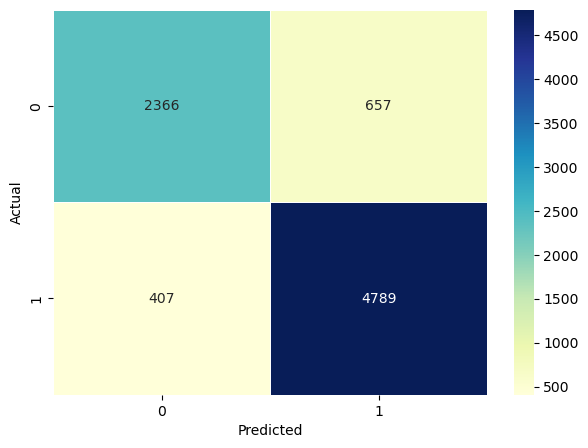

In [33]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

# fit the classifier on the training data
clf_feature = clf_logistic.fit(x_train_vectors, y_train)

# predict the labels of the test data
y_pred = clf_logistic.predict(x_test_vectors)
printStats(y_test, y_pred)

In [34]:
from sklearn.model_selection import cross_val_score

# split the data into 5 folds
cv = 5

# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

# perform k-fold cross-validation and compute the mean accuracy score
scores = cross_val_score(clf_logistic, x_train_vectors, y_train, cv=cv)

# print the mean accuracy score and its standard deviation
print("Mean accuracy: {:.2f}%, Standard deviation: {:.2f}%".format(scores.mean()*100, scores.std()*100))

Mean accuracy: 87.33%, Standard deviation: 0.19%


In [35]:
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

    # define the range of penalty parameter values to explore
param_grid = {'C': [0.01, 0.1, 1, 10]}

    # create a grid search object with 5-fold cross-validation
grid_search = GridSearchCV(clf_logistic, param_grid, cv=5, scoring='accuracy')

    # fit the grid search object on the training data
grid_search.fit(x_train_vectors, y_train)
print("Best parameters:", grid_search.best_params_, "Accuracy Score:", grid_search.best_score_)


Best parameters: {'C': 1} Accuracy Score: 0.8733014920852783


In [36]:
gridSearchLogReg(x_train_vectors, y_train)

Best parameters: {'C': 1} Score: 0.8726660817252724


LogisticRegression(C=1, max_iter=10000)

MSE: 0.129456138216328
R2-score: 0.4432588543007585
F1 score: 0.8582219571164114
Accuracy: 0.8705438617836719


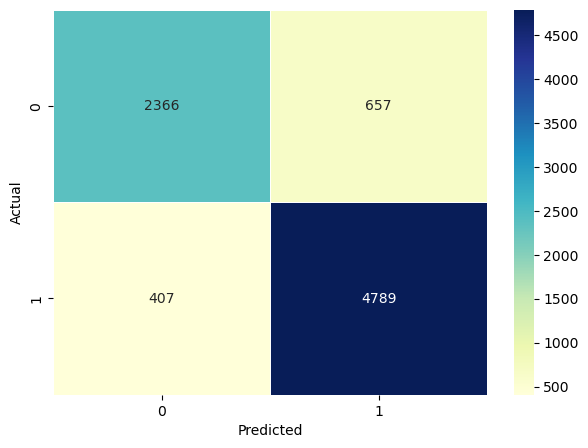

In [37]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000, C=grid_search.best_params_['C'])

# fit the classifier on the training data
clf_logistic.fit(x_train_vectors, y_train)

# predict the labels of the test data
y_pred = clf_logistic.predict(x_test_vectors)
printStats(y_test, y_pred)

In [38]:
# Train the logistic regression model
clf = LogisticRegression(max_iter=10000, random_state=1, C=grid_search.best_params_['C']).fit(x_train_vectors, y_train)

# Extract the coefficient estimates for the additional features
additional_features_coef = clf.coef_[0][-len(feature_cols):]

# Create a dataframe to display the feature importance
importance_df = pd.DataFrame({'feature': feature_cols, 
                              'importance': additional_features_coef})
importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df)


           feature  importance
6  sentiment_score    1.460555
3         latitude    0.525411
0             cool    0.355788
4        longitude    0.238242
5     review_count    0.001177
2           useful   -0.049874
1            funny   -0.099681


In [39]:
permImp(clf_logistic, x_test_vectors, y_test, feature_cols)

sentiment_score: 0.027 +/- 0.002
cool: 0.006 +/- 0.001
funny: 0.001 +/- 0.000
review_count: 0.001 +/- 0.001
latitude: 0.000 +/- 0.000
useful: 0.000 +/- 0.001
longitude: -0.000 +/- 0.000


We eliminate review count, useful, latitude and longitude and repeat the process. 

In [40]:
#refresh the sets
x_train, x_test, y_train, y_test = train_test_split(data, data.positive, 
                                                      test_size = 0.10, random_state = 1)
x_train_vectors = tfidf_vectorizer.transform(x_train.preprocessed_text)
x_test_vectors = tfidf_vectorizer.transform(x_test.preprocessed_text)


In [41]:
feature_cols = ["cool", "funny", "sentiment_score"]
x_train_vectors, x_test_vectors = addFeatures(x_train_vectors, x_test_vectors,
                                             x_train[feature_cols].to_numpy(), 
                                             x_test[feature_cols].to_numpy())

MSE: 0.129456138216328
R2-score: 0.4432588543007585
F1 score: 0.8583551671681322
Accuracy: 0.8705438617836719


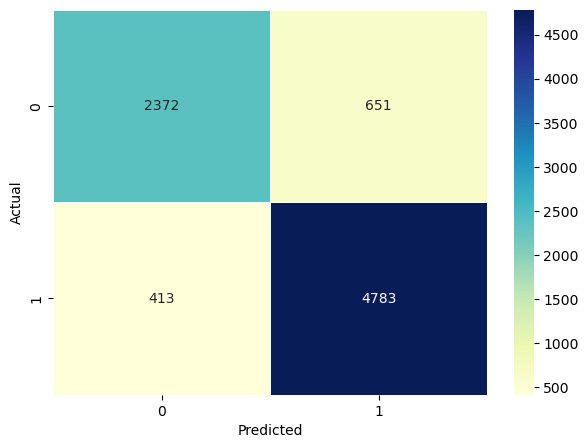

In [42]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000, C=grid_search.best_params_['C'])

# fit the classifier on the training data
clf_logistic= clf_logistic.fit(x_train_vectors, y_train)

# predict the labels of the test data
y_pred = clf_logistic.predict(x_test_vectors)
printStats(y_test, y_pred)

In [43]:
permImp(clf_logistic, x_test_vectors, y_test, feature_cols)

sentiment_score: 0.028 +/- 0.002
cool: 0.005 +/- 0.001
funny: 0.002 +/- 0.001


Remaining three features improved the accuracy score of the base model, are positive. We are keeping these. 

#### 3.2.2.3 Models applied on subset of Vietnamese restaurants

In [44]:
categories_list = data['categories'].tolist()
cat = pd.DataFrame(categories_list, columns=['categories'])

#number of unique categories
print(len(set(categories_list)))



3861


There are 3861 unique "bunch" of categories in this data. We note that this doesn't mean that there are 3861 different category attributes but means that there are 3861 unique combination of these categories.

In [45]:
value_counts = cat.value_counts().head(10).reset_index(name="count")
value_counts

,categories,count
0,"Restaurants, Breakfast & Brunch",1085
1,"Vietnamese, Restaurants",912
2,"Restaurants, Vietnamese",729
3,"Restaurants, Pizza",653
4,"Pizza, Restaurants",469
5,"Sushi Bars, Japanese, Restaurants",463
6,"Restaurants, Steakhouses",459
7,"Canadian (New), Restaurants",435
8,"Chinese, Restaurants",400
9,"Italian, Restaurants",398


Vietnamise restaurants, under two differently ordered but same categories, are the most frequently mentioned (1641 times) category. We subset them to apply the model.

In [47]:
viet = data[data['categories'].isin(['Vietnamese, Restaurants', 'Restaurants, Vietnamese'])]
viet

,business_id,name,latitude,longitude,review_count,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date,positive,preprocessed_text,sentiment_score
1673,U36zxEX-ogh89BIWwLKjSA,Sen Vietnamese Kitchen,50.930691,-113.969588,4,"Restaurants, Vietnamese","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",38C7g-G4tlXTzUUYCebgBw,uJTi6gG31LQw1Im5KEu2VQ,3.0,0,1,0,I am really disappointed with the changes to t...,2018-10-03 16:52:33,0,really disappointed change new menu loved chi ...,0.8228
1674,U36zxEX-ogh89BIWwLKjSA,Sen Vietnamese Kitchen,50.930691,-113.969588,4,"Restaurants, Vietnamese","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",GY9hfBvLNV6trl-TdaTmeQ,1mM1SMzqdHxucYUIUFisNw,4.0,1,1,0,My friend Loretta was visiting from out of tow...,2018-08-20 17:35:08,1,friend loretta visiting town celiac disease ea...,0.9936
1675,U36zxEX-ogh89BIWwLKjSA,Sen Vietnamese Kitchen,50.930691,-113.969588,4,"Restaurants, Vietnamese","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",9_-A0_TTHcQI1zY7CC6iuA,B--fSz4A7l69QpBkbC3NUg,4.0,1,0,0,Today our group of four decided to lunch at Se...,2019-11-07 22:56:02,1,today group four decided lunch sen vietnamese ...,0.9866
1676,U36zxEX-ogh89BIWwLKjSA,Sen Vietnamese Kitchen,50.930691,-113.969588,4,"Restaurants, Vietnamese","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",RyBXtSUtyQwIcyAd1XNzFw,4w7QW3CmKyMmUvupdZqTWQ,5.0,1,0,0,This place is a great addition to the Deep Sou...,2018-12-29 18:47:56,1,place great addition deep south really lacked ...,0.7906
4397,itCmUwEvcuN0fNVD_6BYGw,Pho Xuan Restaurant,51.061414,-113.980825,19,"Vietnamese, Restaurants","{'Monday': '9:0-21:0', 'Tuesday': '9:0-21:0', ...",RjEKvpSoGZD1nbVyWO6Xow,JsbgKWAXtkFMOAlePsN64A,4.0,0,0,0,"Always enjoy eating here, they serve a great p...",2016-02-14 07:48:25,1,always enjoy eating here serve great pho tai a...,0.9670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80566,hSL3GrQ7fjK8a6Boi_jJeQ,Shawnessy Vietnamese Restaurant,50.907419,-114.065549,20,"Restaurants, Vietnamese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",fFMRWSR0Hwq15E2gI-Q5og,eYDG3xOctso7tgope7AFcA,3.0,0,0,0,My recent craving for Sushi isn't that hard fo...,2011-11-22 08:02:43,0,recent craving sushi hard believe thing happen...,0.6597
80567,hSL3GrQ7fjK8a6Boi_jJeQ,Shawnessy Vietnamese Restaurant,50.907419,-114.065549,20,"Restaurants, Vietnamese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",27EIdA2TRecAjDPJoxZ-xw,Dd2guCgG8aMmJsxByrzMAQ,2.0,1,0,0,Salad rolls = average at best .\n\nVietnamese ...,2016-01-16 21:49:15,0,salad roll average best vietnamese chicken d...,0.8074
80568,hSL3GrQ7fjK8a6Boi_jJeQ,Shawnessy Vietnamese Restaurant,50.907419,-114.065549,20,"Restaurants, Vietnamese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",-A3Z2BWQ2mRMVSNWksp0tg,7kvWyj2W7DLSfLqt0ypBVQ,3.0,1,3,1,"I know, I know ...\nHealth code violations, ro...",2011-02-21 10:34:30,0,know know health code violation rodent etc et...,-0.2215
80569,hSL3GrQ7fjK8a6Boi_jJeQ,Shawnessy Vietnamese Restaurant,50.907419,-114.065549,20,"Restaurants, Vietnamese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",huBBh9IW83KpzxhMA7QfdA,Px45T2VBCVjN-CyTNeR-LA,3.0,0,0,0,I just had eaten this last night and a drink a...,2019-11-02 18:56:19,0,eaten last night drink supposably odd reason s...,-0.4404


In [48]:
x_train_viet, x_test_viet, y_train_viet, y_test_viet = train_test_split(viet, viet.positive, 
                                                      test_size = 0.10, random_state = 1)
x_train_vectors_viet = tfidf_vectorizer.transform(x_train_viet.preprocessed_text)
x_test_vectors_viet = tfidf_vectorizer.transform(x_test_viet.preprocessed_text)


MSE: 0.12727272727272726
R2-score: 0.4416693522397679
F1 score: 0.8484848484848484
Accuracy: 0.8727272727272727


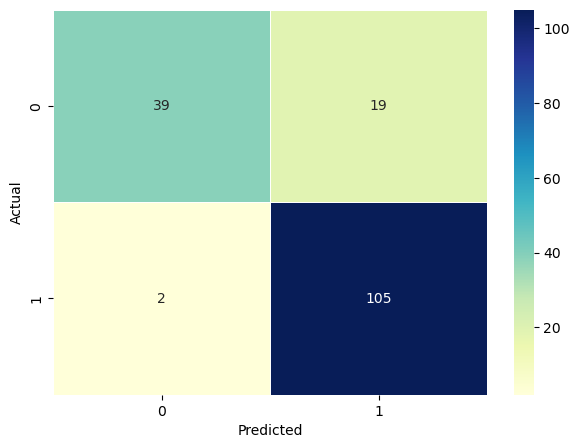

In [49]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000, C=grid_search.best_params_['C'])

# fit the classifier on the training data
clf_logistic.fit(x_train_vectors_viet, y_train_viet)



# predict the labels of the test data
y_pred_viet = clf_logistic.predict(x_test_vectors_viet)
printStats(y_test_viet, y_pred_viet)

In [50]:
feature_cols = ["cool", "funny", "useful", "latitude","longitude", "sentiment_score"]
x_train_vectors_viet, x_test_vectors_viet = addFeatures(x_train_vectors_viet, x_test_vectors_viet,
                                             x_train_viet[feature_cols].to_numpy(), 
                                             x_test_viet[feature_cols].to_numpy())

In [ ]:
# split the data into 5 folds
cv = 5

# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

# perform k-fold cross-validation and compute the mean accuracy score
scores = cross_val_score(clf_logistic, x_train_vectors_viet, y_train_viet, cv=cv)

# print the mean accuracy score and its standard deviation
print("Mean accuracy: {:.2f}%, Standard deviation: {:.2f}%".format(scores.mean()*100, scores.std()*100))

In [51]:
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000)

    # define the range of penalty parameter values to explore
param_grid = {'C': [0.01, 0.1, 1, 10]}

    # create a grid search object with 5-fold cross-validation
grid_search = GridSearchCV(clf_logistic, param_grid, cv=5, scoring='accuracy')

    # fit the grid search object on the training data
grid_search.fit(x_train_vectors_viet, y_train_viet)
print("Best parameters:", grid_search.best_params_, "Accuracy Score:", grid_search.best_score_)


Best parameters: {'C': 10} Accuracy Score: 0.8367178195144298


In [52]:
gridSearchLogReg(x_train_vectors_viet, y_train_viet)

Best parameters: {'C': 10} Score: 0.8299457994579945


LogisticRegression(C=10, max_iter=10000)

MSE: 0.12727272727272726
R2-score: 0.4416693522397679
F1 score: 0.8547839570847826
Accuracy: 0.8727272727272727


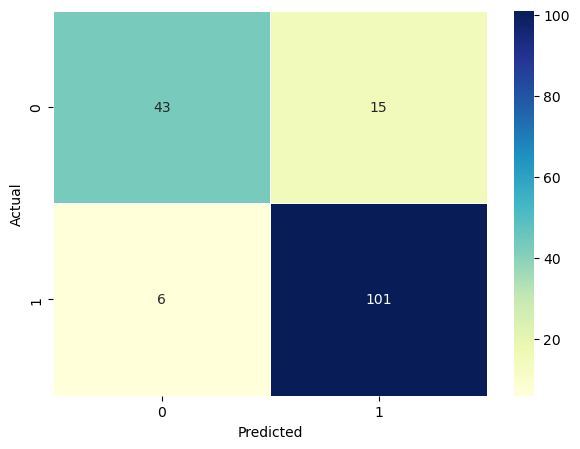

In [53]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000, C=grid_search.best_params_['C'])

# fit the classifier on the training data
clf_logistic.fit(x_train_vectors_viet, y_train_viet)



# predict the labels of the test data
y_pred_viet = clf_logistic.predict(x_test_vectors_viet)
printStats(y_test_viet, y_pred_viet)

In [54]:
permImp(clf_logistic, x_test_vectors_viet, y_test_viet, feature_cols)

sentiment_score: 0.056 +/- 0.021
funny: 0.004 +/- 0.007
longitude: 0.000 +/- 0.000
latitude: 0.000 +/- 0.000
useful: 0.000 +/- 0.000
cool: -0.002 +/- 0.003


In [55]:
#refreshing the set
x_train_viet, x_test_viet, y_train_viet, y_test_viet = train_test_split(viet, viet.positive, 
                                                      test_size = 0.10, random_state = 1)
x_train_vectors_viet = tfidf_vectorizer.transform(x_train_viet.preprocessed_text)
x_test_vectors_viet = tfidf_vectorizer.transform(x_test_viet.preprocessed_text)


In [56]:
feature_cols = ["sentiment_score"]
x_train_vectors_viet, x_test_vectors_viet = addFeatures(x_train_vectors_viet, x_test_vectors_viet,
                                             x_train_viet[feature_cols].to_numpy(), 
                                             x_test_viet[feature_cols].to_numpy())

MSE: 0.12727272727272726
R2-score: 0.4416693522397679
F1 score: 0.8547839570847826
Accuracy: 0.8727272727272727


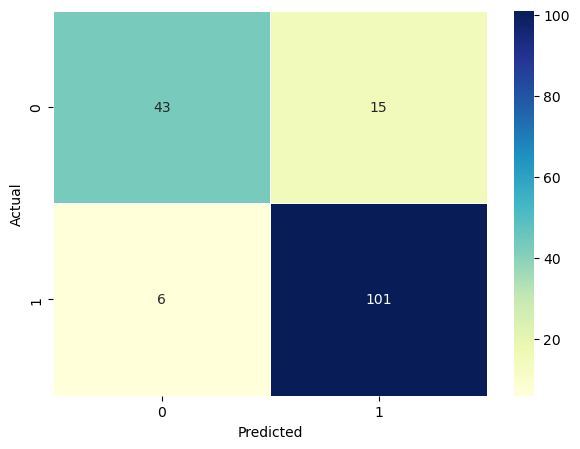

In [57]:
#Logistic Regression
# create an instance of the Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=10000, C=grid_search.best_params_['C'])

# fit the classifier on the training data
clf_logistic.fit(x_train_vectors_viet, y_train_viet)



# predict the labels of the test data
y_pred_viet = clf_logistic.predict(x_test_vectors_viet)
printStats(y_test_viet, y_pred_viet)

In [58]:
permImp(clf_logistic, x_test_vectors_viet, y_test_viet, feature_cols)

sentiment_score: 0.056 +/- 0.022


### 3.2.3 Geospatial analysis and visualisation of review data


### 3.2.4 Extra task 


In [59]:
def plot_top_words(model, feature_names, n_top_words, title, rows=2, columns=5):
    fig, axes = plt.subplots(rows, columns, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7,color='black')
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [71]:
# LDA uses raw term counts 

tf = tfidf_vectorizer.fit_transform(data.preprocessed_text)
tf_feature_names = tfidf_vectorizer.get_feature_names_out()

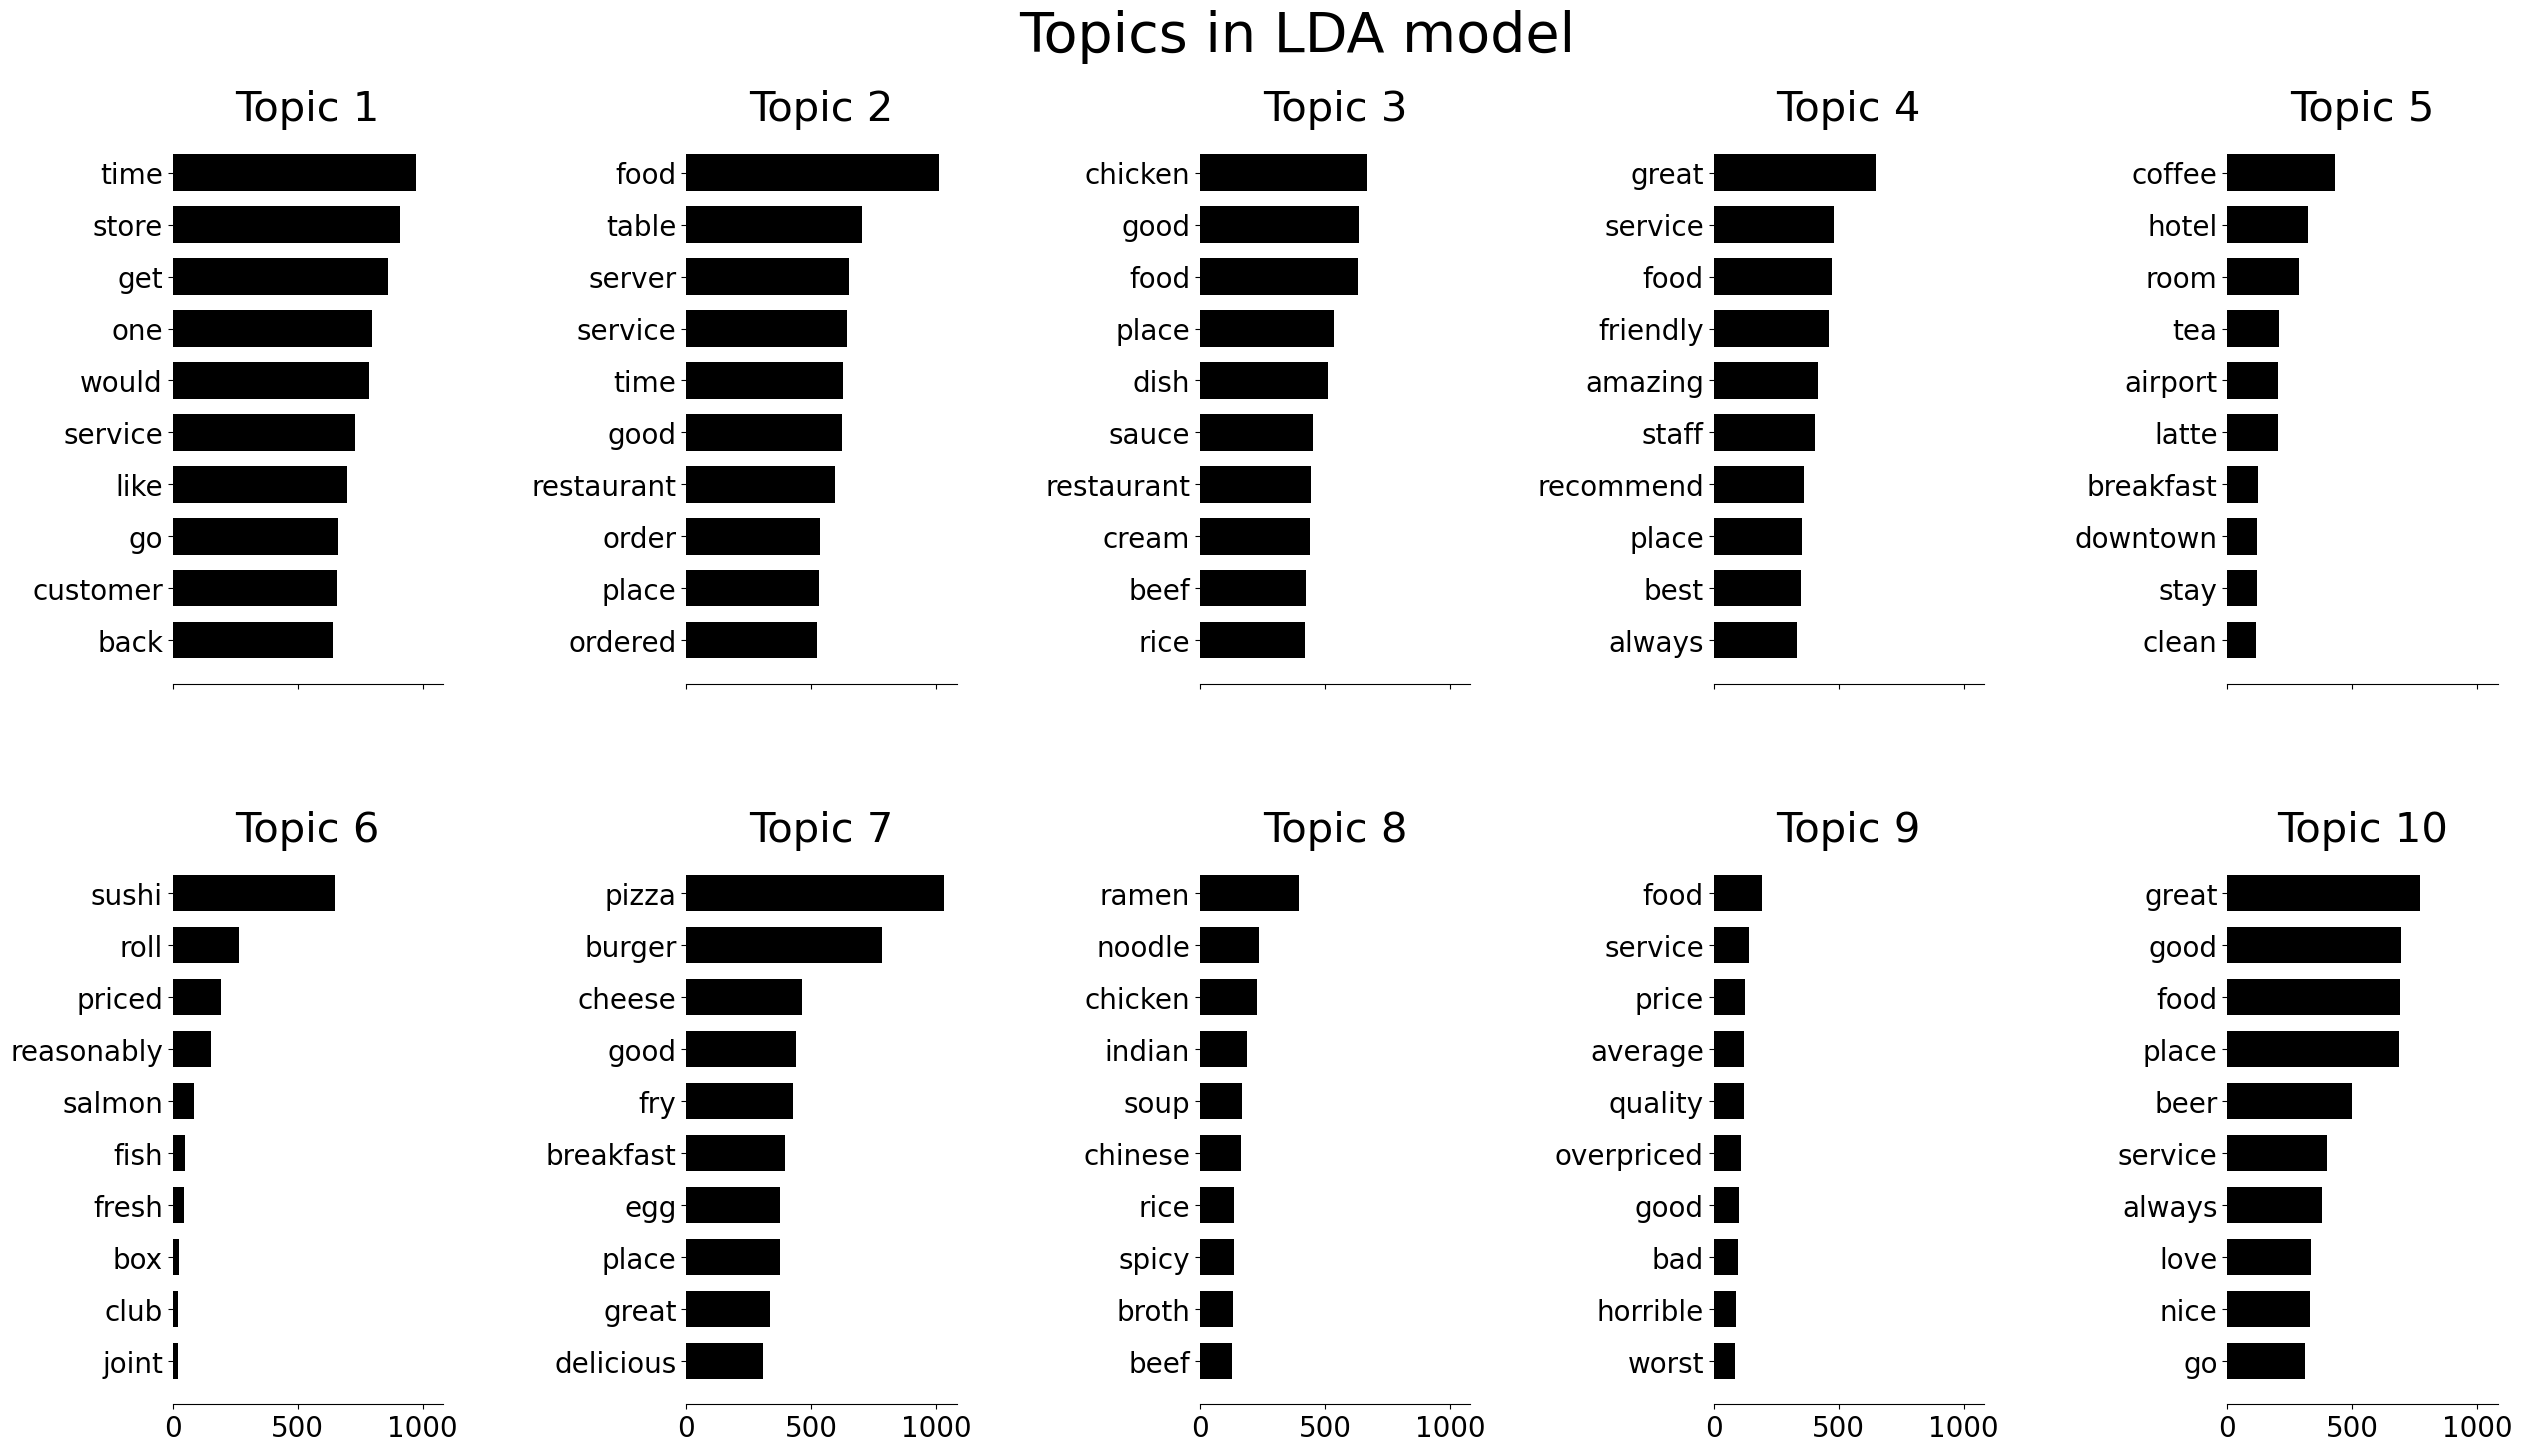

In [62]:
# Run LDA
no_topics=10
lda = LatentDirichletAllocation(no_topics, max_iter=10, 
                                learning_method='online', 
                                learning_offset=50.,random_state=0).fit(tf)
# plot top words

plot_top_words(lda, tf_feature_names, no_top_words, 'Topics in LDA model')

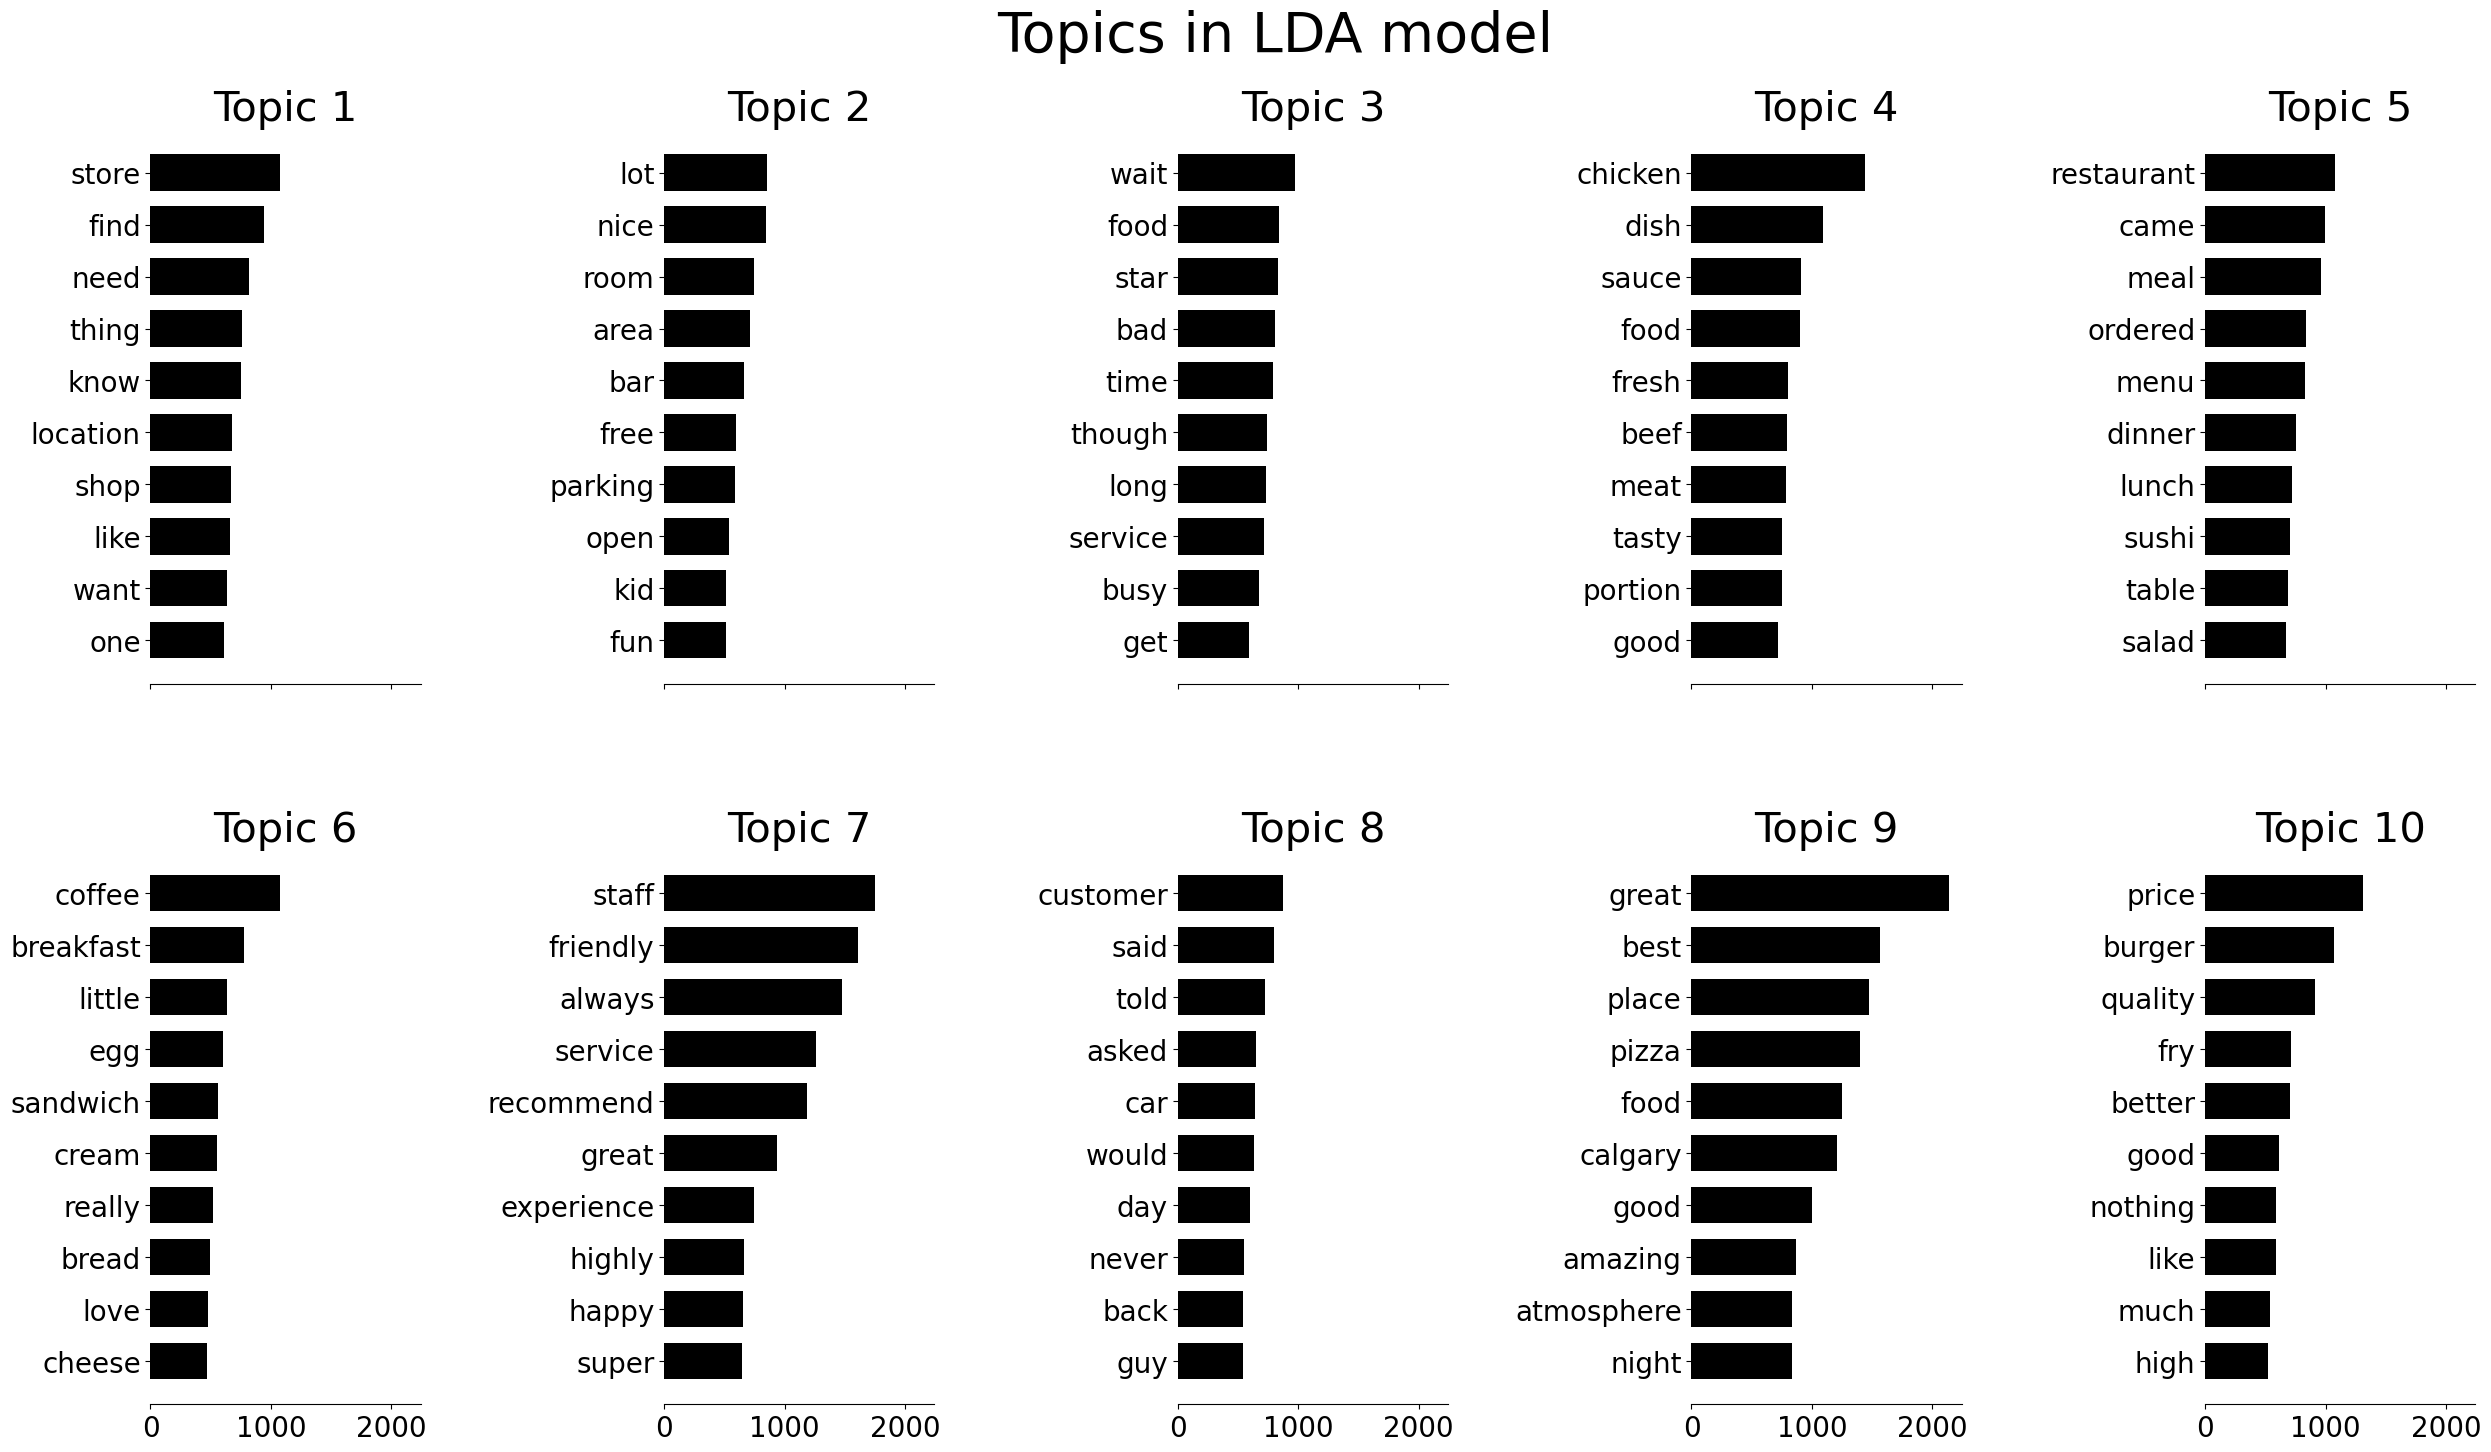

In [72]:
# Run LDA
no_topics=10
alpha= 0.5
lda = LatentDirichletAllocation(no_topics, max_iter=10, 
                                learning_method='online', 
                                learning_offset=50.,random_state=0,
                                doc_topic_prior=alpha).fit(tf)
# plot top words

plot_top_words(lda, tf_feature_names, no_top_words, 'Topics in LDA model')

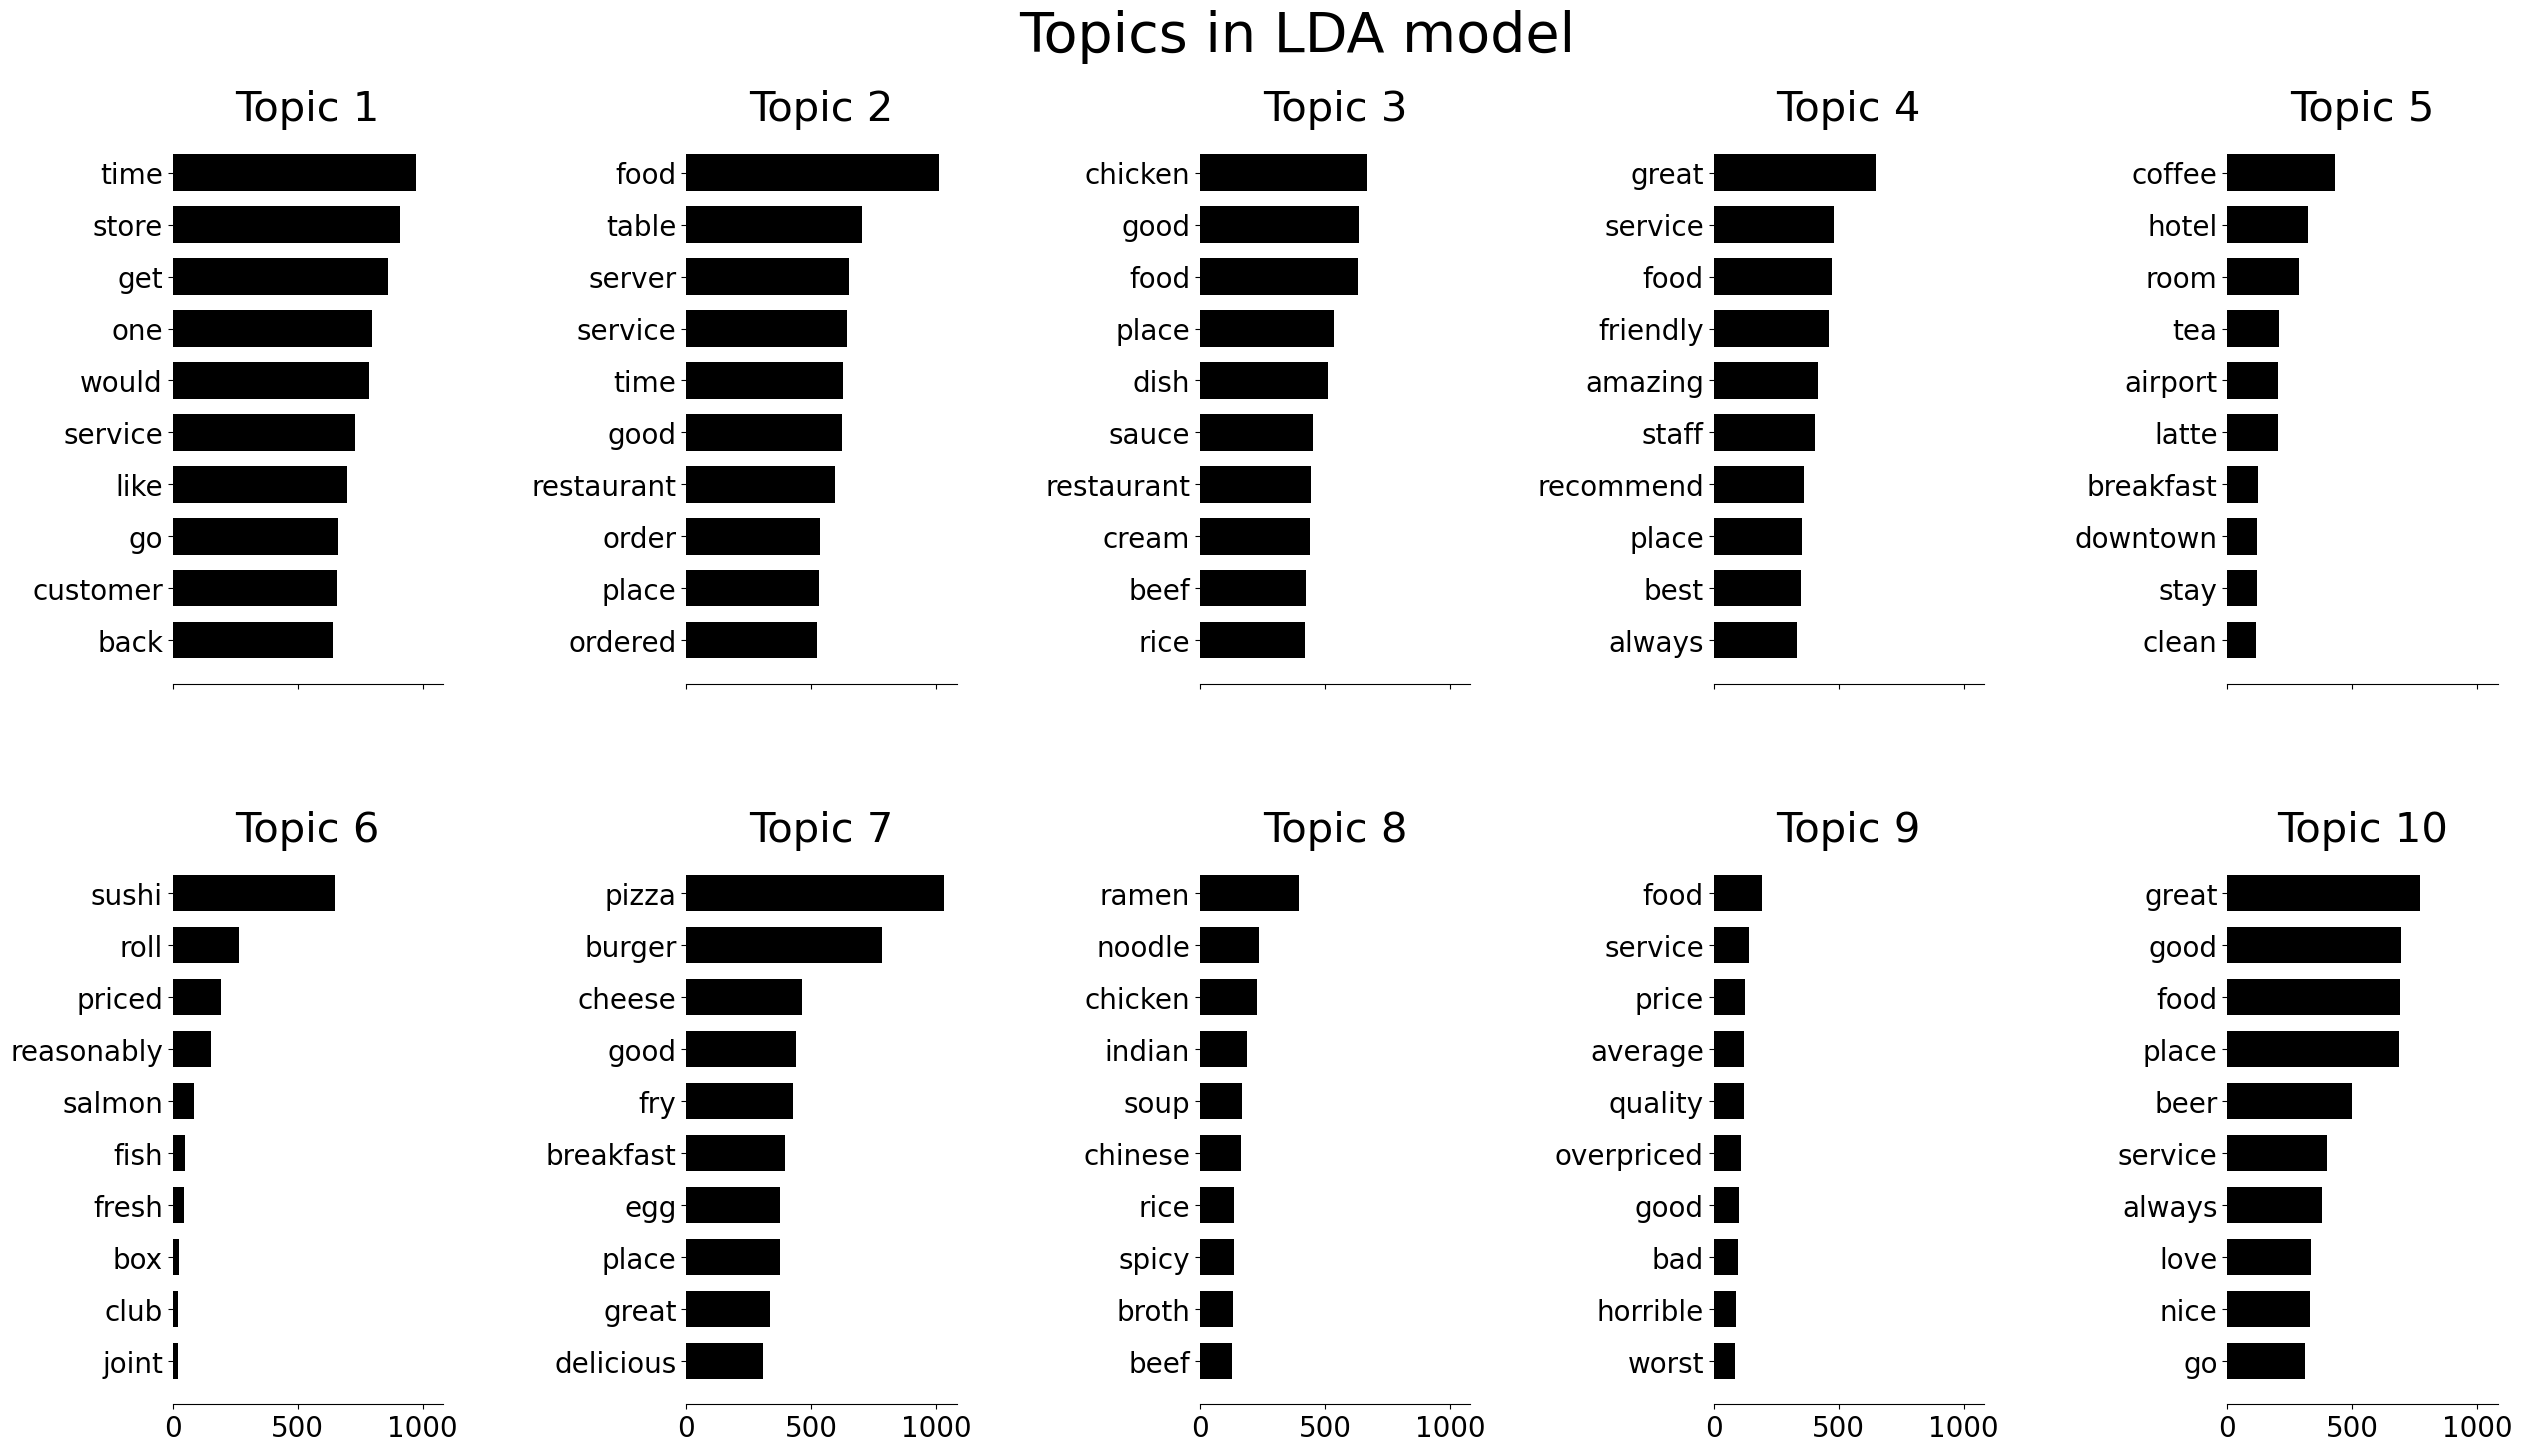

In [67]:
# Run LDA
no_topics=10
eta= 0.1
lda = LatentDirichletAllocation(no_topics, max_iter=10, 
                                learning_method='online', 
                                learning_offset=50.,random_state=0,
                                topic_word_prior=eta).fit(tf)
# plot top words

plot_top_words(lda, tf_feature_names, no_top_words, 'Topics in LDA model')

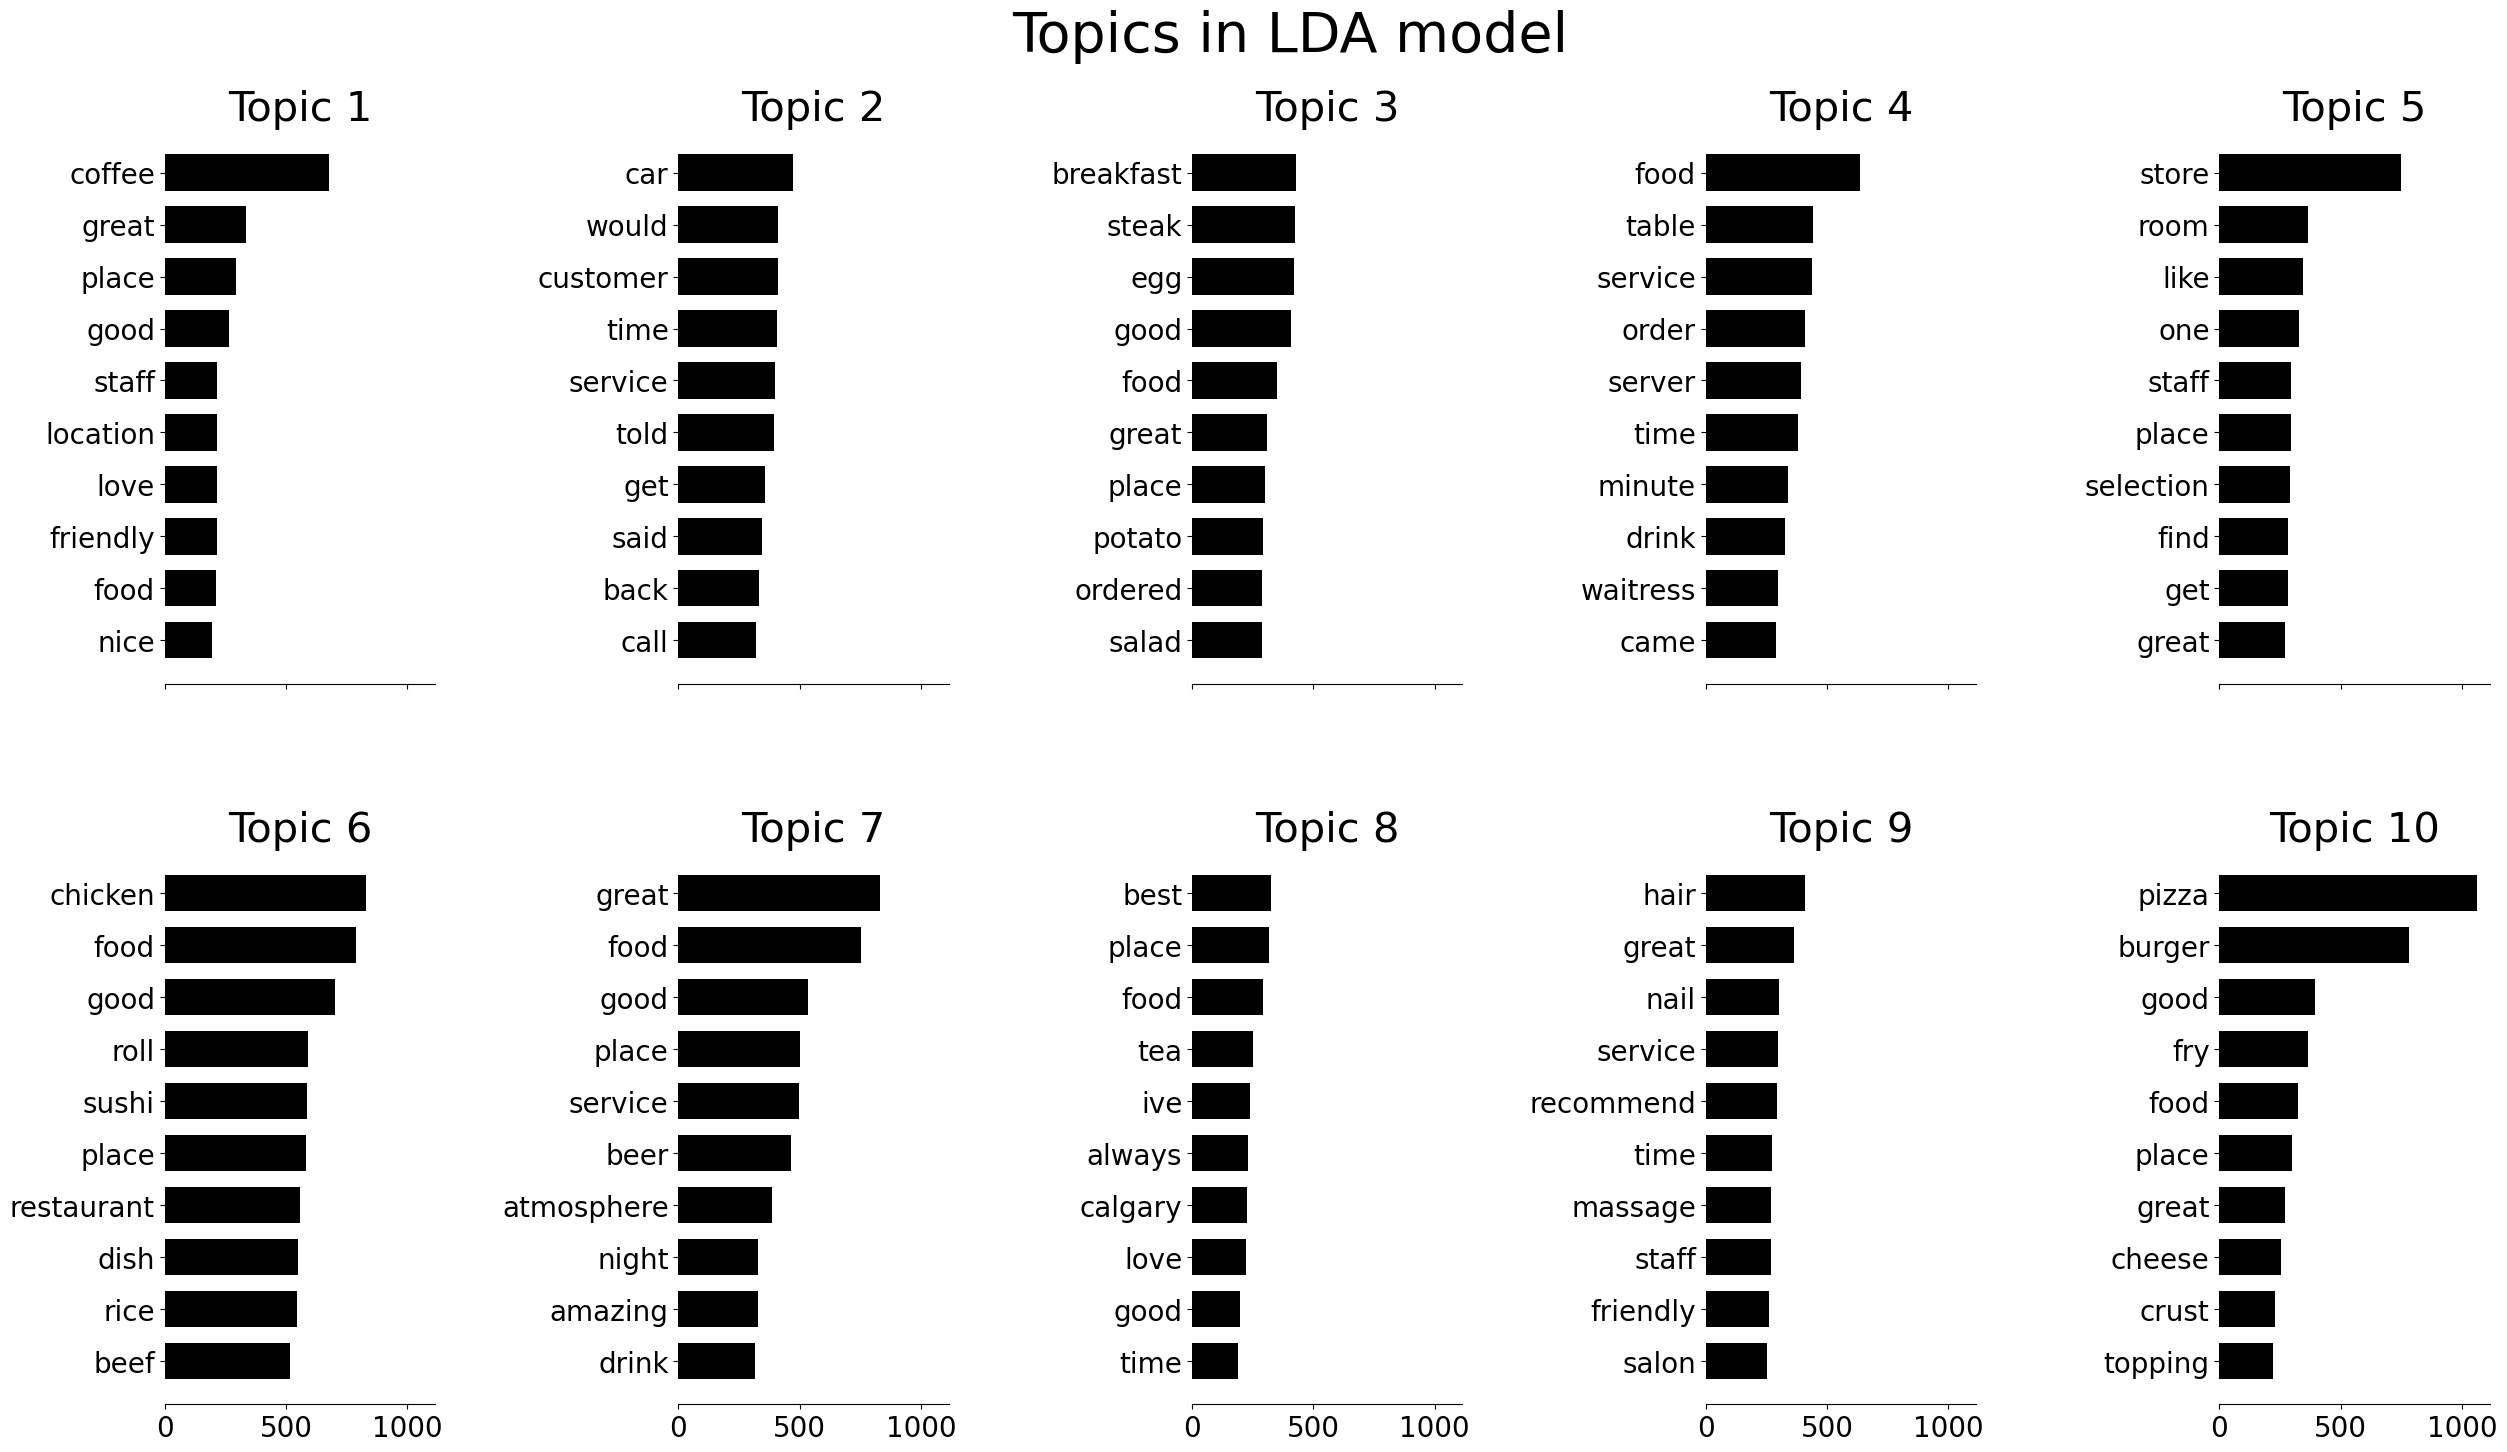

In [66]:
# Run LDA
no_topics=10
lda = LatentDirichletAllocation(no_topics, max_iter=10, 
                                learning_method='batch', 
                                learning_offset=50.,random_state=0).fit(tf)
# plot top words

plot_top_words(lda, tf_feature_names, no_top_words, 'Topics in LDA model')